In [ ]:
# Rastgele Ormanlar ( Random Forests )

# Temeli birden çok karar ağacının ürettiği tahminlerin bir araya getirilerek değerlendirilmesine dayanır.

# Her bir karar ağacı, veri kümesinin rastgele alt kümeleriyle eğitilir ve bu alt kümeler üzerinde kararlar alır.
# Sonuç olarak, her bir ağacın tahminleri bir araya getirilir ve genel tahminler yapılır.

# Ağaç oluşturmada veri setinin 2/3'ü kullanılır.
# Dışarıda kalan veri ağaçların performans değerlendirmesi ve değişken öneminin belirlenmesi için kullanılır.

# Bagging Yöntemi: Aynı algoritmayı kullanarak farklı alt veri kümeleri üzerinde eğitilen birden fazla tahminleyici (model)
# kullanarak daha güçlü bir model oluşturmayı amaçlar.
# Ağaçların birbirine bağımlılıkları yoktur.



# Boosting Yöntemi: Zayıf öğrenicileri sırayla eğitir ve her bir öğrenicinin hatalarını düzeltmeye çalışarak daha güçlü bir
# tahmin modeli elde eder.
# Ağaçlar artıklar üzerine kurulur bu yüzden ağaçların birbirine bağımlılıkları vardır.

In [6]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier

pd.set_option("display.max_columns",None)
warnings.simplefilter(action="ignore", category=Warning)

df = pd.read_csv("diabetes.csv")
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [8]:
###############
# Random Forest
###############

rf_model = RandomForestClassifier(random_state=17)

rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [13]:
# Cross Validation Yöntemi ile Başarı Değerlendirme
cv_result = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy","f1","roc_auc"])

cv_result["test_accuracy"].mean()
cv_result["test_f1"].mean()
cv_result["test_roc_auc"].mean()

0.8233960113960114

In [14]:
# Hiperparametre Optimizasyonu
rf_params = {"max_depth": [5,8,None], # Derinlik
             "max_features": [3,5,7,"auto"], # Bölünmelerde göz önüne alınan değişken sayısı
             "min_samples_split": [2,5,8,15,20], # Gözlem birimi
             "n_estimators": [100,200,500]} # Fit edilecek Ağaç Sayısı

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X,y)

# En iyi değişkenler
rf_best_grid.best_params_

# {'max_depth': None,
# 'max_features': 5,
# 'min_samples_split': 8,
# 'n_estimators': 500}

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [16]:
# Final model
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X,y)

In [18]:
cv_result = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy","f1","roc_auc"])
cv_result["test_accuracy"].mean()
cv_result["test_f1"].mean()
cv_result["test_roc_auc"].mean()

# Hemen hemen tüm metriklerde hiperparametre sonuc vermiş

0.8271054131054132

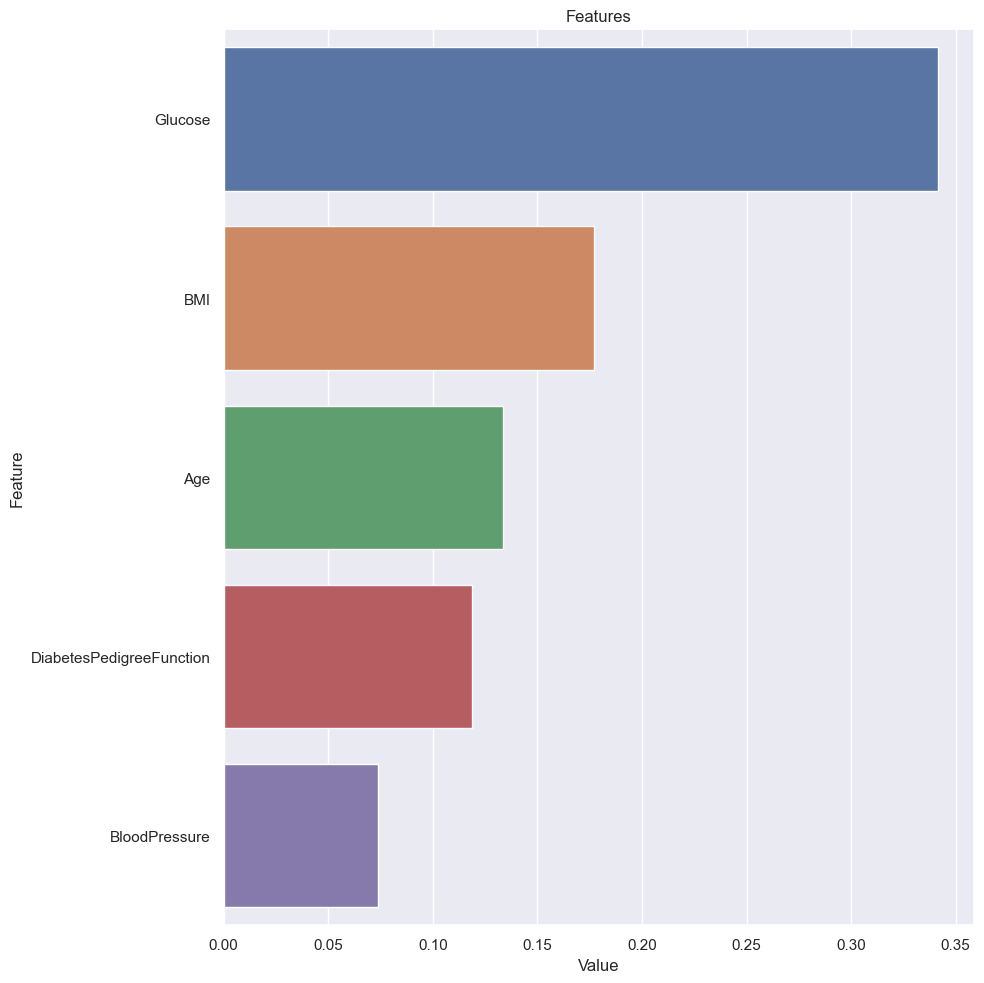

In [19]:
def plot_importance(model,features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value":model.feature_importances_, "Feature":features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value",y="Feature",data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importance.png")
        
# Bir modelin hangi özellikleri daha belirleyici bulduğunu anlamak ve modelin anlamlı özellikleri üzerine
# odaklanmak için kullanılabilir.        

plot_importance(rf_final, X, num=5)

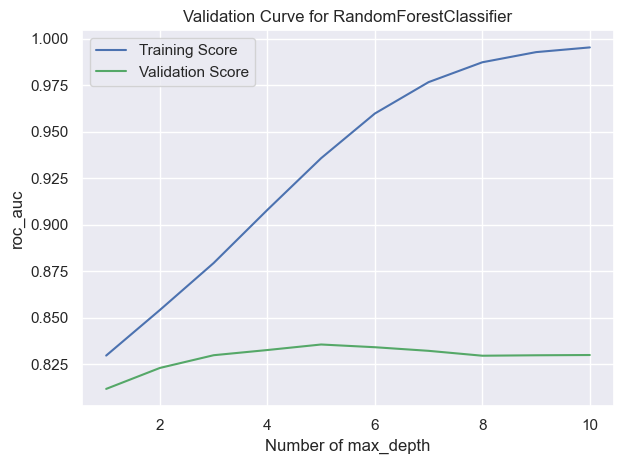

In [20]:
def val_curve_params(model,X,y,param_name,param_range,scoring="roc_auc",cv=10):
    train_score, test_score = validation_curve(
        model, X=X,y=y,param_name=param_name,param_range=param_range,scoring=scoring,cv=cv)
    
    mean_train_score = np.mean(train_score,axis=1)
    mean_test_score = np.mean(test_score,axis=1)
    
    plt.plot(param_range, mean_train_score,label="Training Score",color="b")
    plt.plot(param_range, mean_test_score,label="Validation Score",color="g")
    
    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

# validation_curve fonksiyonunu kullanarak belirtilen hiperparametre aralığında modelin eğitim ve doğrulama skorlarını hesaplar.
# Sonuçları grafik olarak çizer ve ekrana basar.   

val_curve_params(rf_final,X,y,"max_depth",range(1,11),scoring="roc_auc")